In [1]:
import numpy as np
import torch
import torch.optim as optim
import models
import utils
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

## Setting up arguments

In [3]:
args = Namespace(batch_size=128, bound_variance=True, const_var=False, dataset='toy', dropout=0.0, 
                 elbo_weight=1.0, embed_time=128, enc_num_heads=1, intensity=True, k_iwae=1, kl_annealing=False, 
                 kl_zero=False, latent_dim=64, lr=0.0001, mixing='concat', mse_weight=0.0, n=2000, net='hetvae', 
                 niters=2000, norm=True, normalize_input='znorm', num_ref_points=16, rec_hidden=16, recon_loss=False, 
                 sample_tp=0.5, save=True, seed=0, shuffle=True, std=0.1, var_per_dim=False, width=512)

In [4]:
seed = args.seed
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## **Generating Synthetic Data**

In [6]:
data_obj = utils.get_synthetic_data(args)
train_loader = data_obj["train_dataloader"]
test_loader = data_obj["test_dataloader"]
val_loader = data_obj["val_dataloader"]
gt = data_obj['ground_truth']
dim = data_obj["input_dim"]
union_tp = utils.union_time(train_loader)

(2000, 51, 3)
(1600, 51, 3) (320, 51, 3) (400, 51, 3)


## **Loading HeTVAE model**

In [7]:
net = models.load_network(args, dim, union_tp)
params = list(net.parameters())
optimizer = optim.Adam(params, lr=args.lr)

## **Training**

In [8]:
for itr in range(1, args.niters + 1):
      train_loss = 0
      train_n = 0
      avg_loglik, avg_kl, mse, mae = 0, 0, 0, 0
      for train_batch in train_loader:
          batch_len = train_batch.shape[0]
          train_batch = train_batch.to(device)
          subsampled_mask = torch.zeros_like(
              train_batch[:, :, dim:2 * dim]).to(device)
          seqlen = train_batch.size(1)
          for i in range(batch_len):
              length = np.random.randint(low=3, high=10)
              obs_points = np.sort(
                  np.random.choice(np.arange(seqlen), size=length, replace=False)
              )
              subsampled_mask[i, obs_points, :] = 1
          recon_mask = train_batch[:, :, dim:2 * dim] - subsampled_mask
          context_y = torch.cat((
              train_batch[:, :, :dim] * subsampled_mask, subsampled_mask
          ), -1)

          loss_info = net.compute_unsupervised_loss(
              train_batch[:, :, -1],
              context_y,
              train_batch[:, :, -1],
              torch.cat((
                  train_batch[:, :, :dim] * recon_mask, recon_mask
              ), -1),
              num_samples=args.k_iwae,
              beta=1,
          )
          optimizer.zero_grad()
          loss_info.composite_loss.backward()
          optimizer.step()
          train_loss += loss_info.composite_loss.item() * batch_len
          avg_loglik += loss_info.loglik * batch_len
          avg_kl += loss_info.kl * batch_len
          mse += loss_info.mse * batch_len
          mae += loss_info.mae * batch_len
          train_n += batch_len
      if itr % 100 == 0:
          print(
              'Iter: {}, train loss: {:.4f}, avg nll: {:.4f}, avg kl: {:.4f}, '
              'mse: {:.6f}, mae: {:.6f}'.format(
                  itr,
                  train_loss / train_n,
                  -avg_loglik / train_n,
                  avg_kl / train_n,
                  mse / train_n,
                  mae / train_n
              )
          )
          for loader, num_samples in [(val_loader, 5), (test_loader, 100)]:
              utils.evaluate_hetvae(
                  net,
                  dim,
                  loader,
                  0.5,
                  shuffle=False,
                  k_iwae=num_samples,
                  model_name=args.net,
              )

Iter: 100, train loss: 0.9236, avg nll: 0.9232, avg kl: 0.0003, mse: 0.378411, mae: 0.481976
nll: 0.8549, mse: 0.3254, mae: 0.4505, mean_mse: 0.3249, mean_mae: 0.4501
nll: 0.8571, mse: 0.3257, mae: 0.4516, mean_mse: 0.3251, mean_mae: 0.4512
Iter: 200, train loss: 0.6861, avg nll: 0.6859, avg kl: 0.0002, mse: 0.270721, mae: 0.391872
nll: 0.4900, mse: 0.1442, mae: 0.2946, mean_mse: 0.1440, mean_mae: 0.2942
nll: 0.5548, mse: 0.1536, mae: 0.3025, mean_mse: 0.1532, mean_mae: 0.3021
Iter: 300, train loss: 0.5985, avg nll: 0.5984, avg kl: 0.0001, mse: 0.253760, mae: 0.373074
nll: 0.3100, mse: 0.0972, mae: 0.2393, mean_mse: 0.0970, mean_mae: 0.2390
nll: 0.3685, mse: 0.1013, mae: 0.2429, mean_mse: 0.1011, mean_mae: 0.2425
Iter: 400, train loss: 0.5621, avg nll: 0.5620, avg kl: 0.0001, mse: 0.248803, mae: 0.366771
nll: 0.1909, mse: 0.0787, mae: 0.2139, mean_mse: 0.0786, mean_mae: 0.2136
nll: 0.2247, mse: 0.0797, mae: 0.2143, mean_mse: 0.0795, mean_mae: 0.2140
Iter: 500, train loss: 0.5434, avg n

## **Vizualization with increasing number of observations**

In [9]:
def viz(test_loader, k_iwae=1, n_max=20):
    pred_mean, pred_std = [], []
    masks = []
    targets = []
    tp =[]
    np.random.seed(0)
    with torch.no_grad():
        for low in [3, 10, 20]:
            for batch in test_loader:
                batch_len = batch.shape[0]
                batch = batch.to(device)
                subsampled_mask = torch.zeros_like(batch[:, :, dim:2 * dim]).to(device)
                seqlen = batch.size(1)
                for i in range(batch_len):
                    length = np.random.randint(low=low, high=low + 1)
                    obs_points = np.sort(np.random.choice(np.arange(seqlen), size=length, replace=False))
                    subsampled_mask[i, obs_points, :] = 1
                recon_mask = batch[:, :, dim:2 * dim] - subsampled_mask
                context_y = torch.cat((batch[:, :, :dim] * subsampled_mask, subsampled_mask), -1)
                px, _ = net.get_reconstruction(batch[:, :, -1], context_y, batch[:, :, -1], num_samples=k_iwae)
                pred_mean.append(px.mean.cpu().numpy())
                pred_std.append(torch.exp(0.5 * px.logvar).cpu().numpy())
                targets.append((batch[:, :, :dim]).cpu().numpy())
                masks.append(subsampled_mask.cpu().numpy())
                tp.append(batch[:, :, -1].cpu().numpy())
                if len(tp) % (n_max // 5) == 0:
                    break
    
    pred_mean = np.concatenate(pred_mean, axis=1)
    pred_std = np.concatenate(pred_std, axis=1)
    targets = np.concatenate(targets, axis=0)
    masks = np.concatenate(masks, axis=0)
    tp = np.concatenate(tp, axis=0)
    inputs = np.ma.masked_where(masks < 1., targets)
    print(pred_mean.shape, pred_std.shape, targets.shape, masks.shape, tp.shape)
    preds = np.random.randn(k_iwae // 2, k_iwae, pred_mean.shape[1], pred_mean.shape[2], pred_mean.shape[3]) * pred_std + pred_mean
    preds = preds.reshape(-1, pred_mean.shape[1], pred_mean.shape[2], pred_mean.shape[3])
    median = preds.mean(0) #np.quantile(preds, 0.5, axis=0)
    quantile2 = np.quantile(preds, 0.841, axis=0)
    quantile1 = np.quantile(preds, 0.159, axis=0)

    w = 2.0
    for index in range(n_max):
        plt.figure(figsize=(12, 1.5))
        for j in range(3):
            plt.subplot(1, 3, j + 1)
            plt.fill_between(tp[n_max * j + index], quantile1[n_max * j + index, :, 0], quantile2[n_max * j + index, :, 0], alpha=0.6, facecolor='#65c9f7', interpolate=True)
            plt.plot(tp[n_max * j + index], median[n_max * j + index, :, 0], c='b', lw=w, label='Reconstructions')
            plt.plot(tp[n_max * j + index], gt[index], c='r', lw=w, label='Ground Truth')
            plt.scatter(tp[n_max * j + index], inputs[n_max * j + index, :, 0], c='k', lw=w, label='Observed Data')
            plt.xlim([0, 1])
            plt.xticks([])
            plt.yticks([])
            if j == 1 and index == 0:
                plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.6,1.5))
            
        plt.show()

(100, 60, 51, 1) (100, 60, 51, 1) (60, 51, 1) (60, 51, 1) (60, 51)


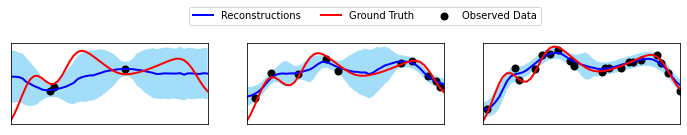

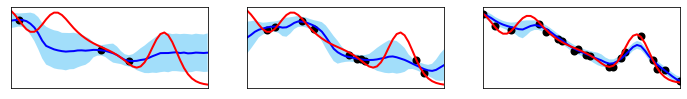

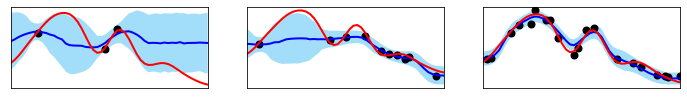

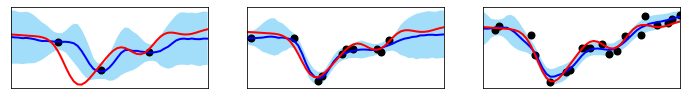

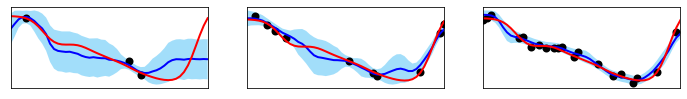

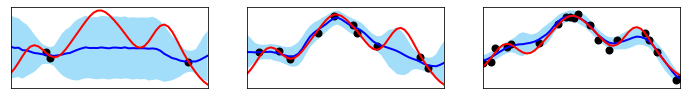

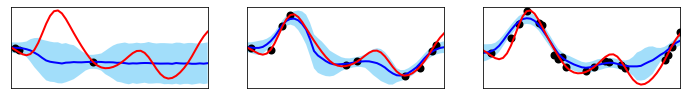

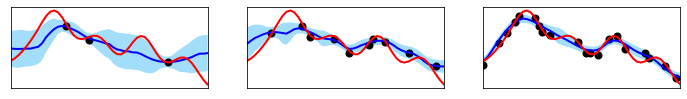

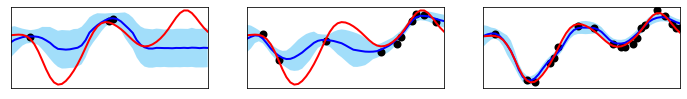

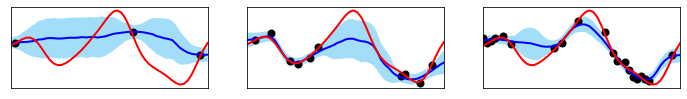

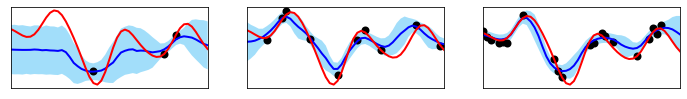

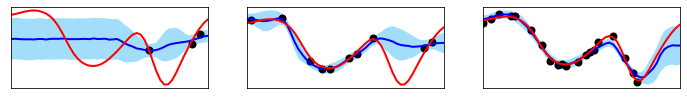

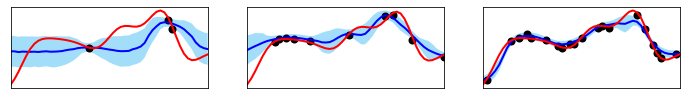

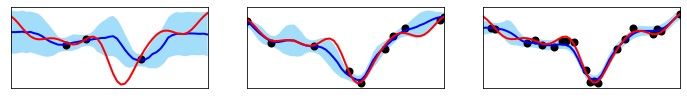

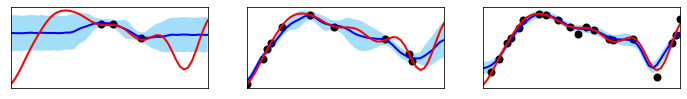

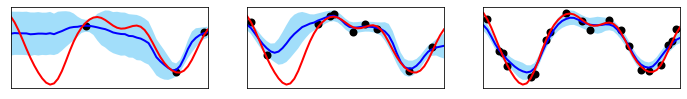

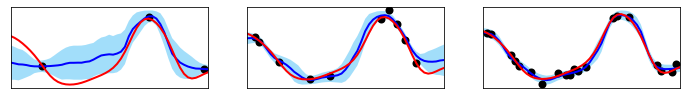

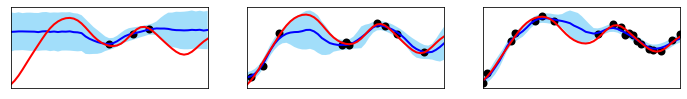

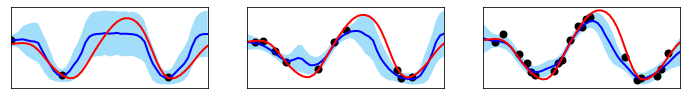

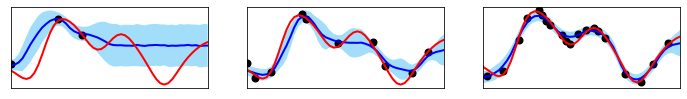

In [10]:
viz(test_loader, k_iwae=100)